In [1]:
import os
import yaml
import fnmatch
from conda_build.metadata import MetaData
from pprint import pprint
import binstar_client
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import networkx as nx

In [2]:
cli = binstar_client.utils.get_server_api()
packages_on_conda_forge = set([f['full_name'].split('/')[1] for f in cli.show_channel('main', 'conda-forge')['files']])

Using Anaconda Cloud api site https://api.anaconda.org


In [3]:
def sanitize_names(list_of_names):
    list_of_names = [name.split(' ')[0] for name in list_of_names]
    list_of_names = [name for name in list_of_names]# if name not in packages_on_conda_forge]
    return list_of_names

In [8]:
# Get the list of folders to check
# get the tagged stack
path = os.path.join(os.path.expanduser("~"), 'dev', 'conda', 'auto-build-tagged-recipes')
folders = [os.path.join(path, 'recipes'), 
           os.path.join(os.path.expanduser('~'), 'dev', 'conda', 'skbeam-recipes', 'recipes')]

In [12]:
os.walk?

In [18]:
run = {}
build = {}
test = {}
for path_to_recipes in folders:
    for dirpath, dirnames, filenames in os.walk(path_to_recipes):
        if 'meta.yaml' not in filenames:
            continue
            # we are not in the right directory
        print("evaluating", dirpath)
        meta = MetaData(dirpath)
        name = meta.meta['package']['name']
        build[name] = sanitize_names(meta.meta.get('requirements', {}).get('build', []))
        run[name] = sanitize_names(meta.meta.get('requirements', {}).get('run', []))
        test[name] = sanitize_names(meta.meta.get('test', {}).get('requires', []))

evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/analysis
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/trackpy-0.3.0
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/tzlocal-1.1.2
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/datamuxer
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/chxtools
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/ixstools
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/pims-0.3.3
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/csxtools
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/ophyd
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/databroker
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/suitcase
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/h5py-2.6.0
evaluating /home/edill/dev/conda/auto-build-tagged-recipes/recipes/super_s

In [66]:
union = {k: set(test.get(k, []) + run.get(k, []) + build.get(k, []))
         for k in set(list(test.keys()) + list(build.keys()) + list(run.keys()))}


In [67]:
# drop all extra packages that I do not have conda recipes for
cleaned_union = {}
for name, items in union.items():
    cleaned_items = set()
    print("Checking", name)
    for item in items:
        if item not in union:
            print('\tdropping', item)
        else:
            cleaned_items.add(item)
    print('\n')
    cleaned_union[name] = cleaned_items

Checking pyxrf
	dropping pillow
	dropping setuptools
	dropping python
	dropping enaml
	dropping matplotlib
	dropping atom
	dropping scipy
	dropping pandas
	dropping six
	dropping numpy
	dropping scikit-image


Checking exceptional
	dropping python
	dropping requests
	dropping ipython


Checking hdf5
	dropping zlib


Checking ophyd
	dropping setuptools
	dropping ipython
	dropping python
	dropping prettytable


Checking py3cairo
	dropping python
	dropping pkg-config
	dropping cairo


Checking pymongo
	dropping python
	dropping setuptools


Checking cairo-gobject
	dropping zlib
	dropping freetype
	dropping pkg-config
	dropping libffi
	dropping glib
	dropping pixman
	dropping cairo
	dropping libpng


Checking csxtools
	dropping ipython
	dropping setuptools
	dropping python
	dropping ipywidgets
	dropping pytest
	dropping matplotlib
	dropping nslsii_dev_configuration
	dropping numpy


Checking analysis
	dropping openpyxl
	dropping python
	dropping ipywidgets
	dropping matplotlib
	dropping al

In [68]:
kw = dict(node_size=5, node_color='w', edge_color='b', alpha=0.25)

def make_network(packages_dict):
    G = nx.DiGraph()
    for package, deps in packages_dict.items():
#         print(package)
        for dep in deps:
#             print('\t{}'.format(dep))
            G.add_edge(package, dep)
    return G

In [69]:
run_G = make_network(run)
build_G = make_network(build)
all_G = make_network(union)

In [70]:
it = iter(all_G)

In [71]:
ret = next(it)

In [72]:
G = all_G.copy()
G.reverse()

In [73]:
G.edges()

[('exceptional', 'python'),
 ('exceptional', 'requests'),
 ('exceptional', 'ipython'),
 ('pymongo', 'python'),
 ('pymongo', 'setuptools'),
 ('filestore', 'boltons'),
 ('filestore', 'doct'),
 ('filestore', 'pims'),
 ('filestore', 'setuptools'),
 ('filestore', 'pyyaml'),
 ('filestore', 'python'),
 ('filestore', 'pymongo'),
 ('filestore', 'nslsii_dev_configuration'),
 ('filestore', 'jsonschema'),
 ('filestore', 'six'),
 ('filestore', 'h5py'),
 ('filestore', 'tifffile'),
 ('filestore', 'numpy'),
 ('eiger-io', 'pims'),
 ('eiger-io', 'six'),
 ('eiger-io', 'setuptools'),
 ('eiger-io', 'h5py'),
 ('eiger-io', 'nslsii_dev_configuration'),
 ('eiger-io', 'python'),
 ('eiger-io', 'filestore'),
 ('eiger-io', 'numpy'),
 ('channelarchiver', 'matplotlib'),
 ('channelarchiver', 'python'),
 ('channelarchiver', 'tzlocal'),
 ('channelarchiver', 'numpy'),
 ('pyolog', 'python'),
 ('pyolog', 'six'),
 ('pyolog', 'requests'),
 ('pyolog', 'setuptools'),
 ('pyolog', 'keyring'),
 ('pyolog', 'ipython'),
 ('tzlocal'

In [74]:
def print_and_trim(graph):
    nodes = [x for x in (G) if G.out_degree(x) == 0]
    for node in nodes:
        G.remove_node(node)
    for idx, node in enumerate(nodes):
        if node not in packages_on_conda_forge:
            nodes[idx] = node.upper()
    pprint(nodes)

print("Packges in all CAPS are packages that still need to be built")
count = 0
while G.nodes():
    print_and_trim(G)
    count += 1
    if count > 50:
        break

Packges in all CAPS are packages that still need to be built
['libtiff',
 'ENAML',
 'matplotlib',
 'keyring',
 'autoconf',
 'cycler',
 'glib',
 'gsl',
 'jsonschema',
 'PKGCONFIG',
 'PYQT',
 'm4',
 'pandas',
 'pixman',
 'tornado',
 'event-model',
 'historydict',
 'ipywidgets',
 'traitlets',
 'OPENPYXL',
 'libpng',
 'zlib',
 'requests',
 'xraylib',
 'SETUPTOOLS',
 'NSLSII_DEV_CONFIGURATION',
 'UJSON',
 'LXML',
 'slicerator',
 'prettytable',
 'PYTEST',
 'ipython',
 'nose',
 'python',
 'ATOM',
 'libffi',
 'automake',
 'PYTABLES',
 'JUPYTER',
 'NUMEXPR',
 'mongoquery',
 'pkg-config',
 'pyyaml',
 'cython',
 'jinja2',
 'scikit-image',
 'libtool',
 'cytoolz',
 'COVERAGE',
 'cairo',
 'boltons',
 'NUMBA',
 'freetype',
 'pillow',
 'numpy',
 'scipy',
 'pytz',
 'six',
 'doct',
 'tifffile',
 'ALBUM',
 'readline']
['EXCEPTIONAL',
 'PYMONGO',
 'PYOLOG',
 'TZLOCAL',
 'XRAY-VISION',
 'SUPER_STATE_MACHINE',
 'hdf5',
 'EPICS-BASE',
 'SPHINX-BOOTSTRAP-THEME',
 'CAIRO-GOBJECT',
 'lmfit',
 'PIMS']
['CHANNELA

In [75]:
G.nodes()

[]

In [76]:
G.edges()

[]

In [77]:
rev = all_G.reverse()
[x for x in rev if rev.out_degree(x) == 0]

['exceptional',
 'eiger-io',
 'pyxrf',
 'csxtools',
 'hkl',
 'collection',
 'ixstools',
 'chxtools',
 'sphinx-bootstrap-theme',
 'trackpy']

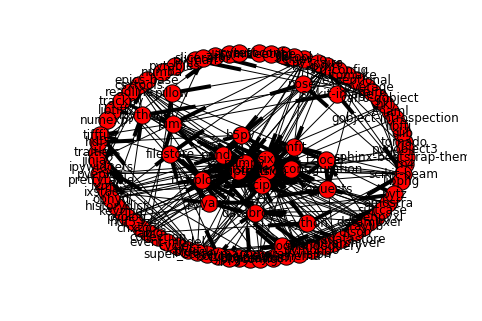

In [78]:
plt.figure()
pos = nx.spring_layout(all_G, k=.2, iterations=200)
nx.draw(all_G, pos, with_labels=True)

In [79]:
def trim_nodes(G, d):
    """Returns a copy of G without the nodes with a degree less than d.
    http://glowingpython.blogspot.com/2012/11/first-steps-with-networx.html
    """
    Gt = G.copy()
    dn = nx.degree(Gt)
    for n in Gt.nodes():
        if dn[n] <= d:
            Gt.remove_node(n)
    return Gt

def plot_deps(G, node, function):
    h = nx.from_dict_of_lists({node: getattr(G, function)(node)})
    nx.draw(h, with_labels=True, **kw)


In [80]:
list(nx.strongly_connected_components(all_G))

[{'python'},
 {'requests'},
 {'ipython'},
 {'exceptional'},
 {'libtiff'},
 {'setuptools'},
 {'pymongo'},
 {'enaml'},
 {'matplotlib'},
 {'keyring'},
 {'autoconf'},
 {'cycler'},
 {'boltons'},
 {'doct'},
 {'tifffile'},
 {'pillow'},
 {'jinja2'},
 {'six'},
 {'scikit-image'},
 {'nose'},
 {'numpy'},
 {'slicerator'},
 {'pims'},
 {'pyyaml'},
 {'jsonschema'},
 {'cython'},
 {'zlib'},
 {'hdf5'},
 {'pkgconfig'},
 {'h5py'},
 {'nslsii_dev_configuration'},
 {'filestore'},
 {'lxml'},
 {'fabio'},
 {'gsl'},
 {'pyqt'},
 {'pytz'},
 {'tzlocal'},
 {'channelarchiver'},
 {'m4'},
 {'pandas'},
 {'pyolog'},
 {'openpyxl'},
 {'tornado'},
 {'scipy'},
 {'metadatastore'},
 {'cytoolz'},
 {'databroker'},
 {'datamuxer'},
 {'historydict'},
 {'atom'},
 {'lmfit'},
 {'xraylib'},
 {'coverage'},
 {'scikit-beam'},
 {'pyxrf'},
 {'ipywidgets'},
 {'traitlets'},
 {'suitcase'},
 {'jupyter'},
 {'super_state_machine'},
 {'event-model'},
 {'xray-vision'},
 {'readline'},
 {'epics-base'},
 {'pyepics'},
 {'bluesky'},
 {'album'},
 {'mongoq

In [81]:
packages_on_conda_forge

{'affine',
 'amqp',
 'antispoofing.utils',
 'antlr',
 'anyjson',
 'apache-libcloud',
 'appdirs',
 'apptools',
 'args',
 'arm_pyart',
 'arrow',
 'artview',
 'assetid',
 'auditwheel',
 'autoconf',
 'automake',
 'autopep8',
 'awesome-slugify',
 'azure',
 'azure-common',
 'azure-mgmt',
 'azure-mgmt-common',
 'azure-mgmt-compute',
 'azure-mgmt-network',
 'azure-mgmt-nspkg',
 'azure-mgmt-resource',
 'azure-mgmt-storage',
 'azure-nspkg',
 'azure-servicebus',
 'azure-servicemanagement-legacy',
 'azure-storage',
 'babel',
 'backports.functools_lru_cache',
 'backports.shutil_get_terminal_size',
 'basemap',
 'basemap-data-hires',
 'bdw-gc',
 'betamax',
 'betamax-matchers',
 'biggus',
 'billiard',
 'binaryornot',
 'binutils',
 'bison',
 'blas',
 'blinker',
 'bob',
 'bob.ap',
 'bob.bio.base',
 'bob.bio.gmm',
 'bob.bio.spear',
 'bob.blitz',
 'bob.core',
 'bob.db.arface',
 'bob.db.atnt',
 'bob.db.atvskeystroke',
 'bob.db.avspoof',
 'bob.db.banca',
 'bob.db.base',
 'bob.db.biosecure',
 'bob.db.biosecu

In [82]:
print("Build Order")
counter = 0
for item in reversed(nx.topological_sort(all_G)):
    if item not in packages_on_conda_forge:
        counter += 1
        print('{:>2}: {}'.format(counter, item))
    else:
        print('##: {}  # Package already on conda-forge'.format(item))

Build Order
##: ipython  # Package already on conda-forge
##: requests  # Package already on conda-forge
##: python  # Package already on conda-forge
 1: exceptional
##: libtiff  # Package already on conda-forge
 2: setuptools
 3: pymongo
 4: enaml
##: matplotlib  # Package already on conda-forge
##: keyring  # Package already on conda-forge
##: autoconf  # Package already on conda-forge
##: cycler  # Package already on conda-forge
 5: nslsii_dev_configuration
##: tifffile  # Package already on conda-forge
##: numpy  # Package already on conda-forge
 6: pkgconfig
##: zlib  # Package already on conda-forge
##: hdf5  # Package already on conda-forge
##: six  # Package already on conda-forge
##: cython  # Package already on conda-forge
##: h5py  # Package already on conda-forge
##: jsonschema  # Package already on conda-forge
##: pyyaml  # Package already on conda-forge
##: slicerator  # Package already on conda-forge
##: nose  # Package already on conda-forge
##: scikit-image  # Package 

In [86]:
import graphviz as gv

def make_gv_network(packages_dict):
    graph = gv.Digraph(format='svg')
    for package, deps in packages_dict.items():
#         if package in packages_on_conda_forge: 
#             continue
        if deps == []:
            graph.node(package)
        for dep in deps:
#             if dep in packages_on_conda_forge:
#                 continue
            graph.edge(package, dep)
    return graph

gvG = make_gv_network(union)
gvG.render('all_dependencies')

'all_dependencies.svg'

In [88]:
graph = gv.Digraph(format='svg')

In [97]:
graph.node('foo', text='pink')

In [90]:
graph.edge('foo', 'bar')

'foo.svg'

In [98]:
graph.render('foo')

'foo.svg'

In [100]:
graph.edge??